<a href="https://colab.research.google.com/github/KeisukeShimokawa/papers-challenge/blob/master/src/gan/biggan/notebooks/biggan_explorer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

path

`src/gan/biggan/notebooks`

## CelebA

In [34]:
!mkdir -p data
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip -O data/celeba.zip
!unzip -q -o -d ./data data/celeba.zip
!rm -rf data/celeba.zip

--2020-05-10 14:02:52--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.24.161
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.24.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘data/celeba.zip’

data/celeba.zip     100%[===================>]   1.34G  94.7MB/s    in 14s     

2020-05-10 14:03:06 (95.3 MB/s) - ‘data/celeba.zip’ saved [1443490838/1443490838]



In [35]:
!ls data/img_align_celeba -1 | wc -l

202599


In [76]:
from PIL import Image

img = Image.open("data/img_align_celeba/000001.jpg")
img.size

(178, 218)

In [95]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

input, target = next(iter(datasets.ImageFolder("data", transform=transforms.Compose([transforms.ToTensor()]))))
input.size()

torch.Size([3, 218, 178])

## DataLoader

In [43]:
!python3 -V

Python 3.6.9


In [36]:
!pip freeze | grep torch

torch==1.5.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.6.0+cu101


In [0]:
import os
import torch
from torchvision import datasets
from torchvision import transforms

In [38]:
print(torch.cuda.get_device_name())
print(torch.cuda.is_available())

Tesla P100-PCIE-16GB
True


In [0]:
class CelebALoader():
    def __init__(self, train=True, dataset="celeba", image_path="data/", 
                 image_size=128, batch_size=64, shuffle=True):
        self.dataset = dataset
        self.path = image_path
        self.imsize = image_size
        self.batch = batch_size
        self.shuffle = shuffle
        self.train = train

    def transform(self, resize, totensor, normalize, centercrop):
        options = []
        if centercrop:
            options.append(transforms.CenterCrop(160))
        if resize:
            options.append(transforms.Resize((self.imsize,self.imsize)))
        if totensor:
            options.append(transforms.ToTensor())
        if normalize:
            options.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
        transform = transforms.Compose(options)
        return transform

    def load_celeb(self):
        transforms = self.transform(True, True, True, True)
        dataset = datasets.ImageFolder(self.path, transform=transforms)
        return dataset

    def get_loader(self):
        dataset = self.load_celeb()

        print(f"dataset: {len(dataset)}")
        loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=self.batch,
                                             shuffle=self.shuffle, num_workers=4,
                                             drop_last=True)
        return loader

In [64]:
data_loader = CelebALoader().get_loader()

dataset: 202599


In [65]:
input, target = next(iter(data_loader))

print(input.size())
print(target.size())

torch.Size([64, 3, 128, 128])
torch.Size([64])


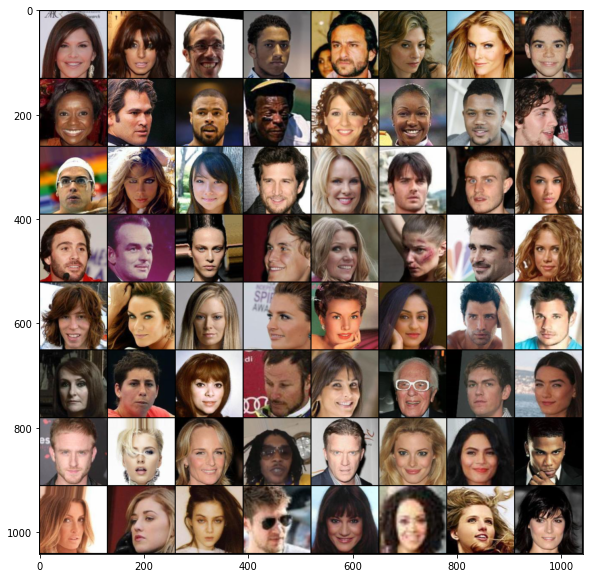

In [67]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(input, normalize=True).permute((1, 2, 0)).numpy());

## Model

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm

This implementation uses `nn.BatchNorm2d` instead of `CrossReplicaBN`

In [0]:
def init_linear(linear):
    init.xavier_uniform_(linear.weight)
    linear.bias.data.zero_()

In [0]:
def init_conv(conv, glu=True):
    init.xavier_uniform_(conv.weight)
    if conv.bias is not None:
        conv.bias.data.zero_()

In [0]:
def leaky_relu(input):
    return F.leaky_relu(input, negative_slope=0.2)

In [0]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim, activation=F.relu):
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_dim , in_dim//8 , kernel_size= 1)
        self.key_conv   = nn.Conv2d(in_dim , in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_dim , in_dim,     kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1)

        init_conv(self.query_conv)
        init_conv(self.key_conv)
        init_conv(self.value_conv)

    def forward(self,x):
        """
            inputs :
                x : input feature maps(B, C, H, W)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out

### Generator

### Discriminator